## User tutorial 2 : few components model

This tutorial show how to set-up and solve a few components model using EESREP. For a full understanding, read the first tutorial before.


This model takes four main components:
-   load : requests a pre-defined amount of energy;
-   cluster : group of N machines providing energy between its minimal and maximal power when turned-on;
-   source_cluster : provides the energy requested by the cluster;
-   source : provides the remaining energy at a higher cost than the cluster.

A "bus" is added to make a low of the nodes between the inputs and the outputs

The structure of the model can be illustrated as follow:

                        source -->  |
                                    | -->  load
    source_cluster --> cluster -->  |

###   Imports

In [1]:
import math

import pandas as pd
import matplotlib.pyplot as plt

from eesrep import Eesrep
from eesrep.components.sink_source import Source, FatalSink
from eesrep.components.converter import Cluster

###   Create model

Create the Eesrep object and every components.

In [2]:
model = Eesrep()

model.add_component(Source("source", 0., 100, 1.))
model.add_component(Source("source_cluster", 0., 100, .5))

model.add_component(Cluster(name="cluster",
                                efficiency=1.,
                                p_max=10.,
                                p_min=1.,
                                n_machine_max=10,
                                duration_on=1,
                                duration_off=1,
                                turn_on_price=0.))

model.add_component(FatalSink("load", 
                                pd.DataFrame({"time": list(range(1001)), 
                                                "value": [i*100/1000 for i in range(1001)]})))

Create the bus and link the components together.

Similarly to the add_link function, the plug_to_bus function takes few arguments:
-   name of the component to plug to the bus;
-   input/output of the component to plug to the bus;
-   name of the bus;
-   if we are plugging an input (boolean);
-   multiplication factor;
-   offset.

In [3]:
model.create_bus("bus", {
                            "name":"bus_1"
                        })
                        
model.plug_to_bus("source", "power_out", "bus_1", False, 1., 0.)
model.plug_to_bus("cluster", "power_out", "bus_1", False, 1., 0.)
model.plug_to_bus("load", "power_in", "bus_1", True, 1., 0.)

model.add_link("source_cluster", "power_out", "cluster", "power_in", 1., 0.)

###   Set up simulation

In this tutorial, we ask EESREP to split the 1000 time steps resolution in 10 * 100 time steps. Each resolution will start 100 steps after the previous, making no overlap between each resolution.

Each resolution is faster, but more are required. A good balance needs to be found between the time range parameters to get a proper result at a good computation time.

In [4]:
model.define_time_range(1., 100, 100, 10)

###   Solve and get results

In [5]:
model.solve()

results = model.get_results(as_dataframe=False)

Running first time step
Running time step 2
Running time step 3
Running time step 4
Running time step 5
Running time step 6
Running time step 7
Running time step 8
Running time step 9
Running time step 10


In [6]:
print(results.keys())
print(results["cluster"].keys())

dict_keys(['source', 'source_cluster', 'cluster', 'load', 'time'])
dict_keys(['power_in', 'power_out', 'turn_on', 'turn_off', 'turn_on_count', 'turn_off_count', 'n_machine'])


The cluster provides all of the requested power as it is cheaper than the other source.

We can see that the cluster turns on machines incrementally as the requested load increases.

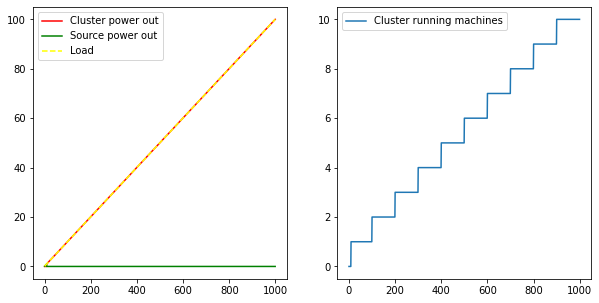

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(results["cluster"]["power_out"], label = "Cluster power out", color="r")
plt.plot(results["source"]["power_out"], label = "Source power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="yellow")
plt.legend()
plt.subplot(122)
plt.plot(results["cluster"]["n_machine"], label = "Cluster running machines")
plt.legend()
plt.show()